In [1]:
!pip install ta --quiet
!pip install torch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
    

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Technical indicators
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
def prepare_data(stock_symbol='AAPL', start_date='2010-01-01', end_date='2020-12-31'):
    # Download historical data
    historical_data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Clean multi-level index if present
    if isinstance(historical_data.columns, pd.MultiIndex):
        cleaned_data = historical_data.droplevel(level=1, axis=1).copy()
    else:
        cleaned_data = historical_data.copy()

    # Store original close prices for reference
    initial_close = cleaned_data['Close'].copy()

    # Add technical indicators
    # RSI
    cleaned_data['RSI'] = RSIIndicator(cleaned_data['Close'], window=14).rsi()

    # MACD
    macd_indicator = MACD(cleaned_data['Close'])
    cleaned_data['MACD'] = macd_indicator.macd()
    cleaned_data['MACD_Signal'] = macd_indicator.macd_signal()
    cleaned_data['MACD_Diff'] = macd_indicator.macd_diff()

    # Bollinger Bands
    bollinger = BollingerBands(close=cleaned_data['Close'])
    cleaned_data['BB_Upper'] = bollinger.bollinger_hband()
    cleaned_data['BB_Middle'] = bollinger.bollinger_mavg()
    cleaned_data['BB_Lower'] = bollinger.bollinger_lband()

    # On-Balance Volume
    cleaned_data['OBV'] = OnBalanceVolumeIndicator(close=cleaned_data['Close'],
                                                  volume=cleaned_data['Volume']).on_balance_volume()

    # Generate lag features
    for lag in range(1, 5):
        cleaned_data[f'Prev_Close_{lag}'] = cleaned_data['Close'].shift(lag)

    # Add Simple Moving Averages
    cleaned_data['SMA50'] = cleaned_data['Close'].rolling(window=50).mean()
    cleaned_data['SMA200'] = cleaned_data['Close'].rolling(window=200).mean()

    # Remove rows with missing values
    cleaned_data = cleaned_data.dropna().copy()

    # Define the features to use
    selected_features = [
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
        'BB_Upper', 'BB_Middle', 'BB_Lower', 'OBV', 'Close',
        'Prev_Close_1', 'Prev_Close_2', 'Prev_Close_3', 'Prev_Close_4',
        'SMA50', 'SMA200'
    ]

    # Normalize the features
    scaler = MinMaxScaler()
    cleaned_data[selected_features] = scaler.fit_transform(cleaned_data[selected_features])

    # Split into training and testing
    training_data = cleaned_data.loc[start_date:'2018-12-31'].copy()
    testing_data = cleaned_data.loc['2019-01-01':end_date].copy()

    return training_data, testing_data, initial_close, selected_features


In [5]:
print("Preparing data...")
stock_symbol = 'AAPL'
training_data, testing_data, initial_close, selected_features = prepare_data(stock_symbol)


Preparing data...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
class StockTradingEnvironment:
    def __init__(self, data, initial_close, selected_features, initial_cash=10000, transaction_cost=0.001):
        self.data = data
        self.initial_close = initial_close  # Original close prices
        self.selected_features = selected_features
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.reset()

    def reset(self):
        self.cash = self.initial_cash
        self.stocks = 0
        self.position = 0  # 0: no position, 1: long
        self.t = 0
        self.portfolio_value = self.cash
        self.transaction_fee = 0
        self.trade_history = []  # Trade results
        self.trades = []  # Individual trade results
        self.portfolio_values = [self.cash]  # Track portfolio value over time
        return self._get_current_state()

    def step(self, action):
        # Get current data
        current_price = self.initial_close.iloc[self.data.index.get_loc(self.data.index[self.t])]

        # Calculate next price (for reward calculation)
        next_idx = self.t + 1
        if next_idx < len(self.data):
            next_price = self.initial_close.iloc[self.data.index.get_loc(self.data.index[next_idx])]
        else:
            next_price = current_price

        # Execute trading action
        reward = 0
        if action == 1 and self.position == 0:  # Buy
            max_stocks = self.cash // (current_price * (1 + self.transaction_cost))
            if max_stocks > 0:
                self.stocks = max_stocks
                cost = self.stocks * current_price * (1 + self.transaction_cost)
                self.transaction_fee = cost - (self.stocks * current_price)
                self.cash -= cost
                self.position = 1

        elif action == 0 and self.position == 1:  # Sell
            if self.stocks > 0:
                revenue = self.stocks * current_price * (1 - self.transaction_cost)
                self.cash += revenue
                trade_profit = revenue - self.transaction_fee - (self.stocks * current_price)
                self.trade_history.append(trade_profit)
                self.trades.append(trade_profit)
                self.stocks = 0
                self.position = 0

        # Move to next timestep
        self.t += 1

        # Calculate new portfolio value and reward
        new_portfolio_value = self.cash + (self.stocks * next_price)
        reward = np.log(new_portfolio_value / self.portfolio_value) if self.portfolio_value > 0 else 0
        self.portfolio_value = new_portfolio_value
        self.portfolio_values.append(new_portfolio_value)

        # Check if episode is done
        done = self.t >= len(self.data) - 1

        # Get next state
        next_state = self._get_current_state() if not done else None

        return next_state, reward, done

    def _get_current_state(self):
        # Get the current state of the environment
        if self.t < len(self.data):
            state = self.data.iloc[self.t][self.selected_features].values
            position_state = np.array([self.position])
            return np.concatenate([state, position_state])
        return None


In [7]:
class ExperienceReplayBuffer:
    def __init__(self, max_capacity):
        self.memory = deque(maxlen=max_capacity)

    def add_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample_batch(self, batch_size):
        return random.sample(self.memory, min(batch_size, len(self.memory)))

    def __len__(self):
        return len(self.memory)

In [8]:
class DoubleDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DoubleDQN, self).__init__()
        # Deep network architecture
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

In [9]:
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim,
                 learning_rate=0.001,
                 discount_factor=0.99,
                 exploration_rate=1.0,
                 min_exploration_rate=0.01,
                 exploration_decay=0.995,
                 buffer_capacity=10000,
                 batch_size=64,
                 target_update_freq=10):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay = exploration_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Initialize replay buffer
        self.memory = ExperienceReplayBuffer(buffer_capacity)

        # Initialize online and target networks
        self.online_network = DoubleDQN(state_dim, action_dim)
        self.target_network = DoubleDQN(state_dim, action_dim)
        self.target_network.load_state_dict(self.online_network.state_dict())
        self.target_network.eval()  # Set target network to evaluation mode

        # Initialize optimizer
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=learning_rate)

        # Loss function
        self.criterion = nn.MSELoss()

        # GPU support if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.online_network.to(self.device)
        self.target_network.to(self.device)

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(self.action_dim)

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.online_network(state_tensor)
            return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.add_experience(state, action, reward, next_state, done)

    def learn_from_experience(self):
        # Check if we have enough experiences to learn from
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of experiences
        batch = self.memory.sample_batch(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)

        # Handle next_states (some may be None for terminal states)
        non_final_mask = torch.BoolTensor([s is not None for s in next_states]).to(self.device)
        non_final_next_states = torch.FloatTensor(np.array([s for s in next_states if s is not None])).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Get current Q values
        current_q_values = self.online_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q values using Double DQN approach
        next_q_values = torch.zeros(self.batch_size).to(self.device)

        if len(non_final_next_states) > 0:
            # Get actions from online network for next states
            with torch.no_grad():
                next_actions = self.online_network(non_final_next_states).max(1)[1].unsqueeze(1)
                # Get Q-values for those actions from target network
                next_q_values[non_final_mask] = self.target_network(non_final_next_states).gather(1, next_actions).squeeze(1)

        # Compute target Q values
        target_q_values = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Compute loss
        loss = self.criterion(current_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.online_network.parameters(), 1.0)
        self.optimizer.step()

        # Increment update counter and update target network if needed
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.online_network.state_dict())

    def adjust_exploration(self):
        if self.exploration_rate > self.min_exploration_rate:
            self.exploration_rate *= self.exploration_decay

    def save_model(self, path):
        torch.save({
            'online_network': self.online_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path)
        self.online_network.load_state_dict(checkpoint['online_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])


In [10]:
def compute_metrics(env):
    portfolio_values = env.portfolio_values

    # Calculate daily returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

    # Total Returns
    initial_cash = env.initial_cash
    final_portfolio_value = portfolio_values[-1]
    total_returns = (final_portfolio_value - initial_cash) / initial_cash

    # Sharpe Ratio (annualized, assuming 252 trading days)
    mean_daily_return = np.mean(daily_returns)
    std_daily_return = np.std(daily_returns)
    sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(252) if std_daily_return != 0 else 0

    # Maximum Drawdown
    rolling_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (rolling_max - portfolio_values) / rolling_max
    max_drawdown = np.max(drawdowns)

    # Win/Loss Ratio
    trades = np.array(env.trades)
    profitable_trades = len(trades[trades > 0])
    losing_trades = len(trades[trades < 0])
    win_loss_ratio = profitable_trades / losing_trades if losing_trades != 0 else float('inf')

    # Annualized Volatility
    annualized_volatility = std_daily_return * np.sqrt(252)

    # Return metrics
    metrics = {
        'Total Returns': total_returns,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Win/Loss Ratio': win_loss_ratio,
        'Annualized Volatility': annualized_volatility,
        'Number of Trades': len(env.trades)
    }

    return metrics

In [11]:
def plot_trading_signals(data, actions, original_close, env):
    plt.figure(figsize=(14, 7))

    # Get the close prices for the testing period
    test_period = data.index
    temp_close = original_close.loc[test_period[0]:test_period[-1]]

    # Plot closing prices
    plt.plot(data.index, temp_close, label='Close Price', color='blue', alpha=0.7)

    # Identify buy and sell signals
    buy_signals = []
    sell_signals = []

    for i in range(1, len(actions)):
        if actions[i] == 1 and actions[i-1] == 0:  # Buy signal
            buy_signals.append((data.index[i], temp_close.iloc[i]))
        elif actions[i] == 0 and actions[i-1] == 1:  # Sell signal
            sell_signals.append((data.index[i], temp_close.iloc[i]))

    # Plot buy signals
    if buy_signals:
        buy_dates, buy_prices = zip(*buy_signals)
        plt.scatter(buy_dates, buy_prices, marker='^', color='green', label='Buy Signal', s=100)

    # Plot sell signals
    if sell_signals:
        sell_dates, sell_prices = zip(*sell_signals)
        plt.scatter(sell_dates, sell_prices, marker='v', color='red', label='Sell Signal', s=100)

    plt.title('Double DQN Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot portfolio value over time
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[:len(env.portfolio_values)], env.portfolio_values, label='Portfolio Value', color='green')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

In [12]:
def moving_average_strategy(data, initial_close):
    # Implement a simple moving average crossover strategy as baseline
    cash = 10000
    stocks = 0
    position = 0  # 0: no position, 1: long
    portfolio_values = [cash]
    transaction_cost = 0.001

    for i in range(1, len(data)):
        prev, curr = data.iloc[i-1], data.iloc[i]
        curr_price = initial_close.iloc[data.index.get_loc(data.index[i])]

        if position == 0 and curr['SMA50'] > curr['SMA200']:  # Buy signal
            stocks = cash // (curr_price * (1 + transaction_cost))
            cash -= stocks * curr_price * (1 + transaction_cost)
            position = 1
        elif position == 1 and curr['SMA50'] < curr['SMA200']:  # Sell signal
            cash += stocks * curr_price * (1 - transaction_cost)
            stocks = 0
            position = 0

        portfolio_value = cash + stocks * curr_price
        portfolio_values.append(portfolio_value)

    return portfolio_values

In [13]:
state_dim = len(selected_features) + 1  # +1 for position state
action_dim = 2

In [14]:
env = StockTradingEnvironment(training_data, initial_close, selected_features)
agent = DoubleDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=0.0005,
    discount_factor=0.99,
    exploration_rate=1.0,
    min_exploration_rate=0.01,
    exploration_decay=0.995,
    buffer_capacity=100000,
    batch_size=64,
    target_update_freq=5
)


In [15]:
num_episodes = 50
print(f"Training for {num_episodes} episodes...")

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)

        if next_state is not None:
            agent.store_experience(state, action, reward, next_state, done)
        else:
            agent.store_experience(state, action, reward, state, done)  # Use current state if next is None

        agent.learn_from_experience()
        state = next_state if next_state is not None else state
        total_reward += reward

    agent.adjust_exploration()

    # Print progress
    if (episode + 1) % 5 == 0 or episode == 0:
        print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")

# Save the trained model
agent.save_model(f"{stock_symbol}_double_dqn_model.pth")
print("Training complete. Model saved.")

Training for 50 episodes...
Episode 1/50, Total Reward: -0.3841, Exploration Rate: 0.9950
Episode 5/50, Total Reward: 0.1914, Exploration Rate: 0.9752
Episode 10/50, Total Reward: -0.2659, Exploration Rate: 0.9511
Episode 15/50, Total Reward: -0.1292, Exploration Rate: 0.9276
Episode 20/50, Total Reward: 0.4809, Exploration Rate: 0.9046
Episode 25/50, Total Reward: 0.0051, Exploration Rate: 0.8822
Episode 30/50, Total Reward: -0.1727, Exploration Rate: 0.8604
Episode 35/50, Total Reward: 1.3646, Exploration Rate: 0.8391
Episode 40/50, Total Reward: 0.9719, Exploration Rate: 0.8183
Episode 45/50, Total Reward: 0.7974, Exploration Rate: 0.7981
Episode 50/50, Total Reward: 0.0482, Exploration Rate: 0.7783
Training complete. Model saved.


In [16]:
test_env = StockTradingEnvironment(testing_data, initial_close, selected_features)
state = test_env.reset()
actions = []
done = False


In [17]:
agent.exploration_rate = 0

while not done:
    action = agent.choose_action(state)
    next_state, reward, done = test_env.step(action)
    actions.append(action)
    state = next_state if next_state is not None else state

In [18]:
metrics = compute_metrics(test_env)
print("\nDouble DQN Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



Double DQN Performance Metrics:
Total Returns: 0.2735
Sharpe Ratio: 0.8253
Maximum Drawdown: 0.1397
Win/Loss Ratio: 0.0000
Annualized Volatility: 0.1629
Number of Trades: 22.0000


In [19]:
print("\nCalculating baseline strategy performance...")
baseline_values = moving_average_strategy(testing_data, initial_close)
baseline_daily_returns = np.diff(baseline_values) / baseline_values[:-1]
baseline_total_return = (baseline_values[-1] - 10000) / 10000
baseline_sharpe = (np.mean(baseline_daily_returns) / np.std(baseline_daily_returns)) * np.sqrt(252) if np.std(baseline_daily_returns) != 0 else 0

print(f"Baseline Total Return: {baseline_total_return:.4f}")
print(f"Baseline Sharpe Ratio: {baseline_sharpe:.4f}")



Calculating baseline strategy performance...
Baseline Total Return: 0.1499
Baseline Sharpe Ratio: 0.5155


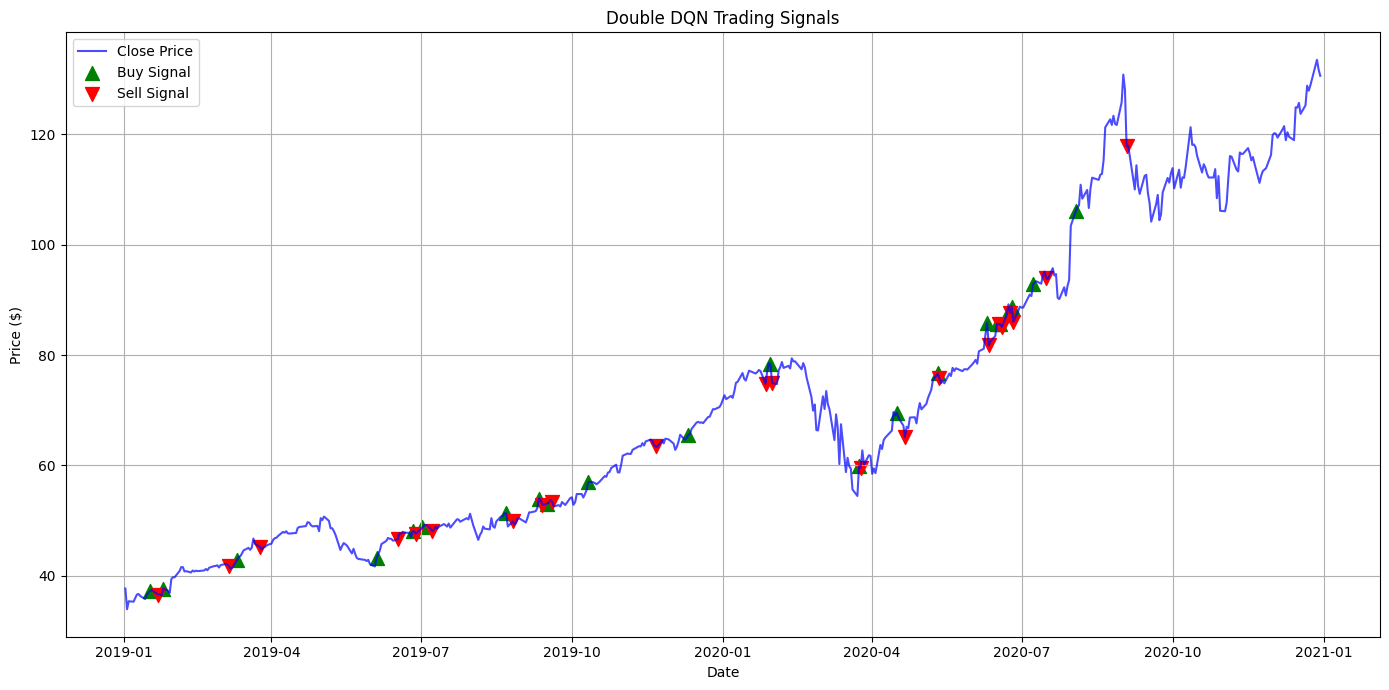

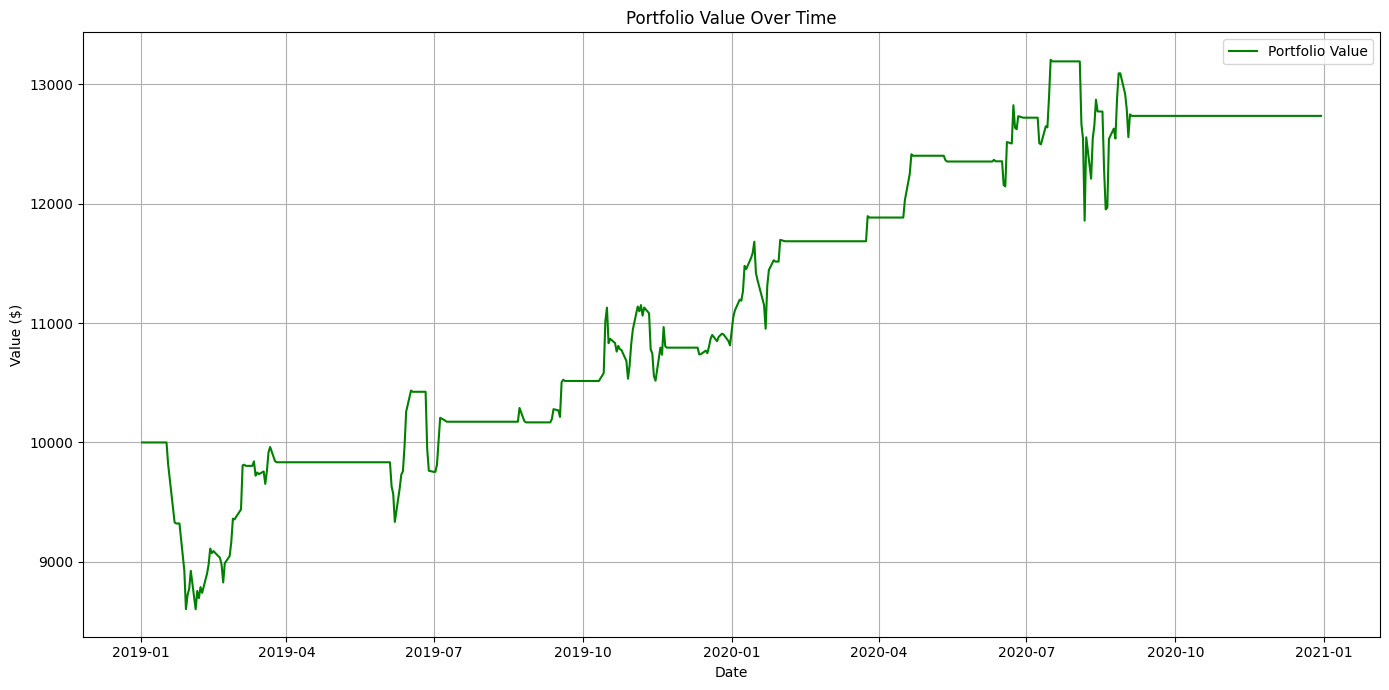

In [20]:
# Plot trading signals and portfolio value
plot_trading_signals(testing_data, actions, initial_close, test_env)